# Assignment 01 - Digit Recognizer

Identifying written digits using the [MNIST dataset](https://www.kaggle.com/competitions/digit-recognizer/overview)

Thiago Amado Costa

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm 
from sklearn.model_selection import train_test_split 
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
import tensorflow as tf
from keras.applications import VGG16
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from keras import Model
import joblib

## Reading Dataset
- Label = written digit
- pixelx = pixels of the image
- image is 28x28 (pixel0 .. pixel27 as first row, and so on)

In [3]:
df = pd.read_csv('data/train.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y = df['label']
X = df.drop('label', axis=1)

- plotting number 04 as example

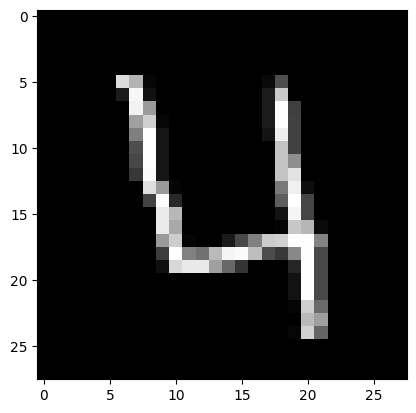

In [5]:
num_4 = X.values.reshape(-1,28,28,1)[3]
plt.imshow(num_4, cmap='grey')

- Train and test splitting 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

## Baseline Model

- Dummy model as a base for comparing with other ml models and cnn

In [7]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
s = dummy.score(X_test, y_test)
print(f'Dummy accuracy: {s}')

Dummy accuracy: 0.10821428571428572


## Training - SVM

### Linear Kernel

In [7]:
i = 10000

model = svm.SVC(random_state=42, kernel='linear')
model.fit(X_train.values[:i], y_train.values[:i])
s = model.score(X_test.values, y_test.values)
print(f'SVM linear accuracy: {s}')

SVM linear accuracy: 0.9148809523809524


### Polynomial Kernel

In [8]:
model = svm.SVC(random_state=42, kernel='poly')
model.fit(X_train.values[:i], y_train.values[:i])
s = model.score(X_test.values, y_test.values)
print(f'SVM poly accuracy: {s}')

SVM poly accuracy: 0.9538095238095238


- Pipeline : normalize values between 0 and 1, and classify with SVM with polynomial kernel

In [9]:
pipe = Pipeline([('normalizer', Normalizer()), ('svc', svm.SVC(kernel='poly'))])
# joblib.dump(pipe, 'models/pipe.joblib')
pipe.fit(X_train.values, y_train.values)
s = pipe.score(X_test.values, y_test.values)
print(f'Pipeline accuracy: {s}')

Pipeline accuracy: 0.9809523809523809


## Training - CNN

- reshaping the inputs into 28x28 nparrays
- normalizing values between 0 and 1
- transforming values to shape (32,32,3), to use with VGG16

In [14]:
X_train = X_train.values.reshape(-1,28,28)
X_train = X_train / 255.0 
X_test = X_test.values.reshape(-1,28,28)
X_test = X_test / 255.0 

X_train=tf.image.grayscale_to_rgb(tf.expand_dims(X_train, axis=3)) 
X_test=tf.image.grayscale_to_rgb(tf.expand_dims(X_test, axis=3))
X_train=tf.image.resize_with_pad(X_train,32,32)
X_test=tf.image.resize_with_pad(X_test,32,32)

In [15]:
base = VGG16(include_top=False, input_shape=(32,32,3), weights='imagenet')

_x = base.output
_x = Flatten()(_x)
_x = Dense(512, activation='relu')(_x)
_x = Dense(64, activation='relu')(_x)
predictions = Dense(10, activation='softmax')(_x)
cnn = Model(inputs=base.input, outputs=predictions)

for layer in cnn.layers[:11]:
    layer.trainable = False
    
# for i, layer in enumerate(cnn.layers):
#     print(i, layer.name, layer.trainable)

cnn.compile(optimizer=Adam(0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Epoch 1/7
263/263 [==============================] - 394s 1s/step - loss: 0.0945 - accuracy: 0.9720 - val_loss: 0.0525 - val_accuracy: 0.9848
Epoch 2/7
263/263 [==============================] - 401s 2s/step - loss: 0.0427 - accuracy: 0.9874 - val_loss: 0.0541 - val_accuracy: 0.9860
Epoch 3/7
263/263 [==============================] - 361s 1s/step - loss: 0.0282 - accuracy: 0.9912 - val_loss: 0.0274 - val_accuracy: 0.9927
Epoch 4/7
263/263 [==============================] - 348s 1s/step - loss: 0.0246 - accuracy: 0.9928 - val_loss: 0.0385 - val_accuracy: 0.9877
Epoch 5/7
263/263 [==============================] - 346s 1s/step - loss: 0.0186 - accuracy: 0.9944 - val_loss: 0.0420 - val_accuracy: 0.9877
Epoch 6/7
263/263 [==============================] - 347s 1s/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.0303 - val_accuracy: 0.9913
Epoch 7/7
263/263 [==============================] - 346s 1s/step - loss: 0.0169 - accuracy: 0.9951 - val_loss: 0.0302 - val_accuracy: 0.9907


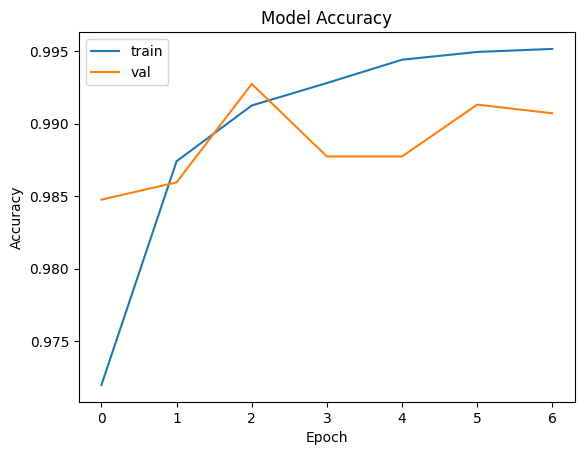

In [17]:
history = cnn.fit(X_train, y_train, epochs=7, batch_size=128, validation_data=(X_test, y_test))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Results Analysis

The problem of classifying handwritten digits with the MNIST dataset is considered a beginner problem in Machine Learning, serving as a base for benchmarking different models. In this notebook, a Dummmy classifier was created, to show the success rate one would have by just 'guessing', which was approximately 11 % of accuracy.
A better ML approach to the problem is by using SVM. By using svm with the Linear kernel, the model gets a good result, but the result is improved by changing the kernel to Polynomial, when training with a sample of 10000 of the train data. Then, to improve the model accuracy, training with all the samples, and using Normalization, SVM with polynomial kernel gets a accuracy of 98 %.
Another ML approach is to create a CNN. In this case, transfer learning is beeing used, with the VGG16 model, and by training for 7 epochs, with batch size of 128, the max accuracy in the validation data was of 99,3 %.

Key points :
 - A simpler ML approach, like linear SVM, is enough to get a good accuracy in this dataset, even when training with a sample of the ds.
 - To improve it, change the kernel to Linear and add a Normalization to the pipeline.
 - a CNN approach will get better results, at the cost of more training time 